# USAJobs Historical Data Analysis

This notebook provides sample queries and analysis for the USAJobs historical dataset stored in DuckDB.

## Data Overview
- **Total**: 2,947,854 jobs across 11 years (2015-2025)
- **Coverage**: 90.6% of expected days from 2015-01-01 to 2025-06-07
- **Note**: Limited data for 2015 (140 jobs) and 2016 (3,879 jobs)

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import glob
import os

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("📦 Libraries loaded successfully!")

📦 Libraries loaded successfully!


## 1. Connect to DuckDB Databases

We'll connect to all available DuckDB files and create a unified view.

In [2]:
# Find all DuckDB files
duckdb_files = sorted(glob.glob("data/duckdb/usajobs_*.duckdb"))
print(f"🔍 Found {len(duckdb_files)} DuckDB files:")
for db in duckdb_files:
    print(f"  - {os.path.basename(db)}")

# Create connection to in-memory database
conn = duckdb.connect(':memory:')
print("\n✅ Connected to DuckDB")

🔍 Found 11 DuckDB files:
  - usajobs_2015.duckdb
  - usajobs_2016.duckdb
  - usajobs_2017.duckdb
  - usajobs_2018.duckdb
  - usajobs_2019.duckdb
  - usajobs_2020.duckdb
  - usajobs_2021.duckdb
  - usajobs_2022.duckdb
  - usajobs_2023.duckdb
  - usajobs_2024.duckdb
  - usajobs_2025.duckdb

✅ Connected to DuckDB


In [3]:
# Attach all databases and create unified view
print("🔗 Attaching databases...")

for i, db_file in enumerate(duckdb_files):
    db_name = f"db_{os.path.basename(db_file).replace('.duckdb', '').replace('-', '_')}"
    print(f"  Attaching {os.path.basename(db_file)} as {db_name}")
    conn.execute(f"ATTACH '{db_file}' AS {db_name}")

print("\n✅ All databases attached!")

🔗 Attaching databases...
  Attaching usajobs_2015.duckdb as db_usajobs_2015
  Attaching usajobs_2016.duckdb as db_usajobs_2016
  Attaching usajobs_2017.duckdb as db_usajobs_2017
  Attaching usajobs_2018.duckdb as db_usajobs_2018
  Attaching usajobs_2019.duckdb as db_usajobs_2019
  Attaching usajobs_2020.duckdb as db_usajobs_2020
  Attaching usajobs_2021.duckdb as db_usajobs_2021
  Attaching usajobs_2022.duckdb as db_usajobs_2022
  Attaching usajobs_2023.duckdb as db_usajobs_2023
  Attaching usajobs_2024.duckdb as db_usajobs_2024
  Attaching usajobs_2025.duckdb as db_usajobs_2025

✅ All databases attached!


In [4]:
# Create unified view by combining all tables
print("🔄 Creating unified view...")

# Get the first database with data to create the initial table
first_db = None
for db_file in duckdb_files:
    db_name = f"db_{os.path.basename(db_file).replace('.duckdb', '').replace('-', '_')}"
    try:
        count = conn.execute(f"SELECT COUNT(*) FROM {db_name}.historical_jobs").fetchone()[0]
        if count > 0:
            first_db = db_name
            break
    except:
        continue

if first_db:
    # Create the unified table starting with the first database
    conn.execute(f"CREATE OR REPLACE TABLE all_jobs AS SELECT * FROM {first_db}.historical_jobs")
    
    # Add data from other databases
    for db_file in duckdb_files:
        db_name = f"db_{os.path.basename(db_file).replace('.duckdb', '').replace('-', '_')}"
        if db_name != first_db:
            try:
                conn.execute(f"INSERT INTO all_jobs SELECT * FROM {db_name}.historical_jobs")
            except Exception as e:
                print(f"  ⚠️ Error adding {db_name}: {e}")
    
    # Get final count
    total_jobs = conn.execute("SELECT COUNT(*) FROM all_jobs").fetchone()[0]
    print(f"\n✅ Unified view created with {total_jobs:,} total jobs")
else:
    print("❌ No databases with data found!")

🔄 Creating unified view...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


✅ Unified view created with 2,947,854 total jobs


## 2. Basic Data Exploration

In [5]:
# Basic statistics
print("📊 Dataset Overview:")
print("=" * 50)

# Total jobs
total = conn.execute("SELECT COUNT(*) FROM all_jobs").fetchone()[0]
print(f"Total jobs: {total:,}")

# Date range
date_range = conn.execute("""
    SELECT 
        MIN(position_open_date) as earliest,
        MAX(position_open_date) as latest
    FROM all_jobs
""").fetchone()
print(f"Date range: {date_range[0]} to {date_range[1]}")

# Unique agencies
agencies = conn.execute("SELECT COUNT(DISTINCT hiring_agency_name) FROM all_jobs").fetchone()[0]
print(f"Unique agencies: {agencies:,}")

# Jobs by year
jobs_by_year = conn.execute("""
    SELECT 
        EXTRACT(year FROM position_open_date) as year,
        COUNT(*) as job_count
    FROM all_jobs 
    GROUP BY year 
    ORDER BY year
""").fetchdf()

print("\n📅 Jobs by Year:")
for _, row in jobs_by_year.iterrows():
    year = int(row['year'])
    count = row['job_count']
    if year in [2015, 2016]:
        print(f"  {year}: {count:,} ⚠️ Limited data")
    else:
        print(f"  {year}: {count:,}")

📊 Dataset Overview:
Total jobs: 2,947,854
Date range: 2015-01-01 to 2025-06-07
Unique agencies: 561

📅 Jobs by Year:
  2015: 140 ⚠️ Limited data
  2016: 3,879 ⚠️ Limited data
  2017: 237,145
  2018: 327,905
  2019: 349,256
  2020: 326,376
  2021: 366,943
  2022: 441,487
  2023: 454,036
  2024: 367,193
  2025: 73,494


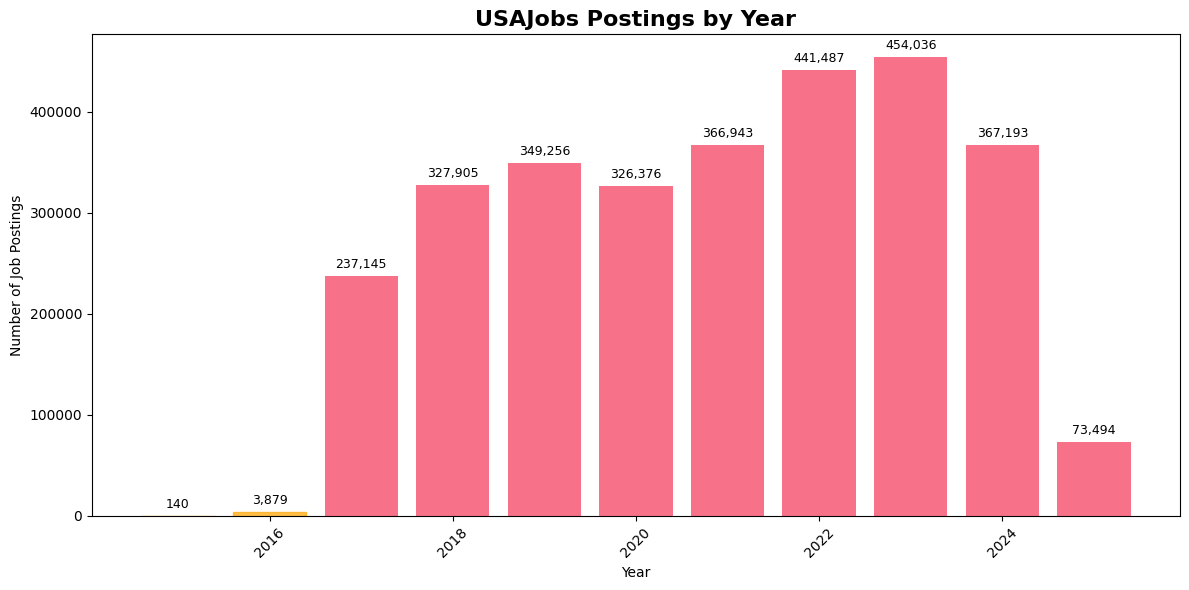

In [6]:
# Visualize jobs by year
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(jobs_by_year['year'], jobs_by_year['job_count'])

# Highlight limited data years
for i, bar in enumerate(bars):
    year = jobs_by_year.iloc[i]['year']
    if year in [2015, 2016]:
        bar.set_color('orange')
        bar.set_alpha(0.7)

ax.set_title('USAJobs Postings by Year', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Job Postings')
ax.tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(jobs_by_year['job_count']):
    ax.text(jobs_by_year.iloc[i]['year'], v + 5000, f'{v:,}', 
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 3. Top Hiring Agencies

In [7]:
# Top 15 hiring agencies
top_agencies = conn.execute("""
    SELECT 
        hiring_agency_name,
        COUNT(*) as job_count
    FROM all_jobs 
    WHERE hiring_agency_name IS NOT NULL
    GROUP BY hiring_agency_name 
    ORDER BY job_count DESC 
    LIMIT 15
""").fetchdf()

print("🏢 Top 15 Hiring Agencies:")
print("=" * 60)
for i, row in top_agencies.iterrows():
    print(f"{i+1:2d}. {row['hiring_agency_name']:<40} {row['job_count']:>8,}")

🏢 Top 15 Hiring Agencies:
 1. Veterans Health Administration            665,509
 2. Army Installation Management Command       92,637
 3. Army National Guard Units                  82,375
 4. U.S. Army Corps of Engineers               70,479
 5. Commander, Navy Installations              56,714
 6. U.S. Marine Corps                          56,111
 7. U.S. Army Medical Command                  54,672
 8. U.S. Army Reserve Command                  51,568
 9. Internal Revenue Service                   49,394
10. Justice, Bureau of Prisons/Federal Prison System   47,384
11. Air National Guard Units                   42,774
12. National Park Service                      41,366
13. Federal Aviation Administration            38,694
14. Air Force Materiel Command                 36,321
15. Forest Service                             34,660


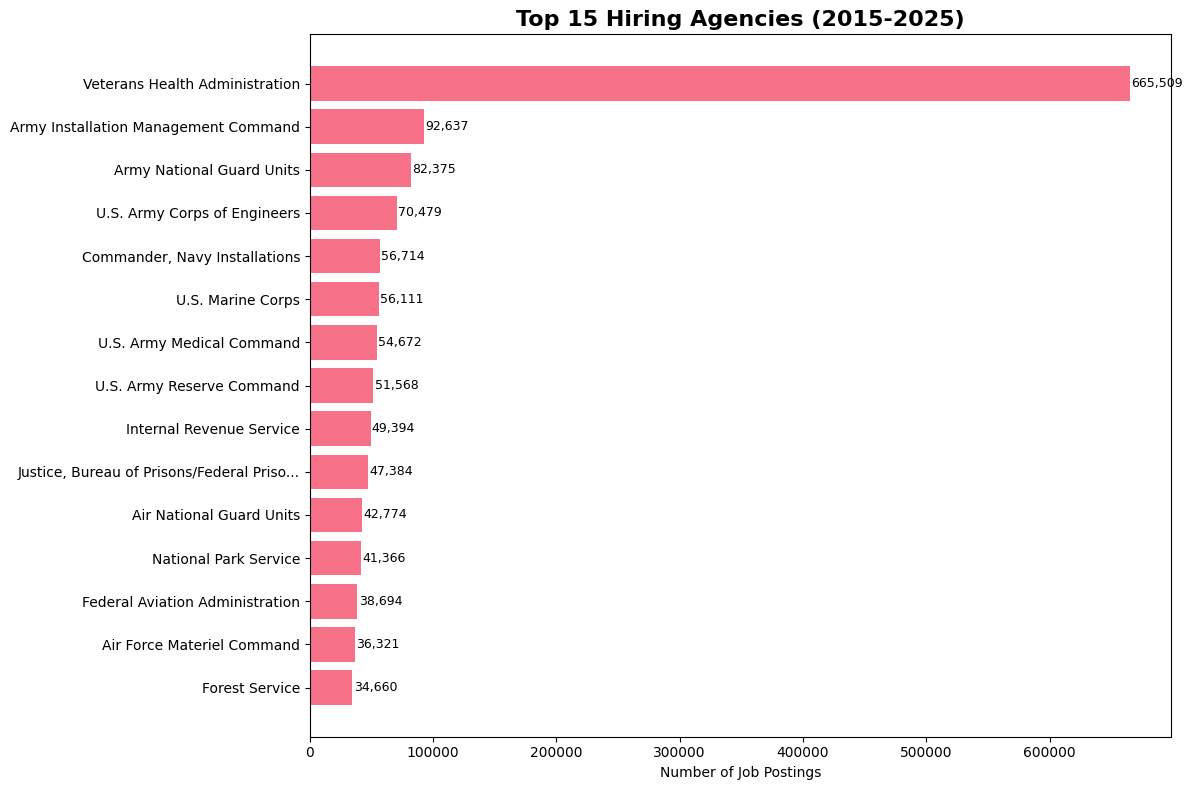

In [8]:
# Visualize top agencies
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(range(len(top_agencies)), top_agencies['job_count'])

# Customize the plot
ax.set_yticks(range(len(top_agencies)))
ax.set_yticklabels([agency[:40] + '...' if len(agency) > 40 else agency 
                    for agency in top_agencies['hiring_agency_name']])
ax.set_xlabel('Number of Job Postings')
ax.set_title('Top 15 Hiring Agencies (2015-2025)', fontsize=16, fontweight='bold')

# Add value labels
for i, v in enumerate(top_agencies['job_count']):
    ax.text(v + 1000, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.gca().invert_yaxis()  # Show highest at top
plt.show()

## 4. Product Manager Jobs Analysis

Let's dive deep into product manager related positions across the federal government.

In [9]:
# Product manager job search query
product_manager_query = """
SELECT *
FROM all_jobs 
WHERE 
    LOWER(position_title) LIKE '%product manager%'
    OR LOWER(position_title) LIKE '%product management%'
    OR LOWER(position_title) LIKE '%product owner%'
    OR LOWER(position_title) LIKE '%product lead%'
    OR LOWER(position_title) LIKE '%head of product%'
    OR LOWER(position_title) LIKE '%director of product%'
    OR LOWER(position_title) LIKE '%vp of product%'
    OR LOWER(position_title) LIKE '%vice president of product%'
    OR LOWER(position_title) LIKE '%chief product officer%'
    OR (LOWER(position_title) LIKE '%product%' AND LOWER(position_title) LIKE '%strategist%')
"""

# Get product manager jobs
pm_jobs = conn.execute(product_manager_query).fetchdf()

print(f"🎯 Product Manager Analysis")
print(f"=" * 50)
print(f"Total product manager jobs found: {len(pm_jobs):,}")

if len(pm_jobs) > 0:
    print(f"Date range: {pm_jobs['position_open_date'].min()} to {pm_jobs['position_open_date'].max()}")
    print(f"Unique agencies: {pm_jobs['hiring_agency_name'].nunique()}")
else:
    print("No product manager jobs found!")

🎯 Product Manager Analysis
Total product manager jobs found: 537
Date range: 2017-03-01 00:00:00 to 2025-04-28 00:00:00
Unique agencies: 57


📅 Product Manager Jobs by Year:
  2017: 32 jobs
  2018: 35 jobs
  2019: 35 jobs
  2020: 59 jobs
  2021: 53 jobs
  2022: 98 jobs
  2023: 99 jobs
  2024: 116 jobs
  2025: 10 jobs


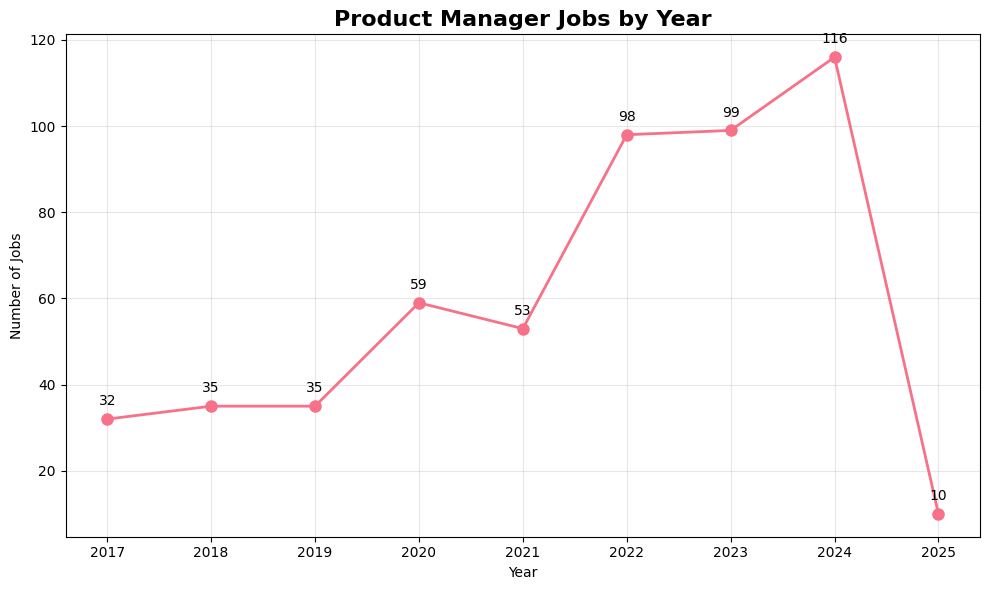

In [10]:
# Product manager jobs by year
if len(pm_jobs) > 0:
    pm_jobs['year'] = pd.to_datetime(pm_jobs['position_open_date']).dt.year
    pm_by_year = pm_jobs.groupby('year').size().reset_index(name='count')
    
    print("📅 Product Manager Jobs by Year:")
    for _, row in pm_by_year.iterrows():
        print(f"  {int(row['year'])}: {row['count']:,} jobs")
    
    # Visualize PM jobs by year
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(pm_by_year['year'], pm_by_year['count'], marker='o', linewidth=2, markersize=8)
    ax.set_title('Product Manager Jobs by Year', fontsize=16, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Jobs')
    ax.grid(True, alpha=0.3)
    
    # Add value labels
    for _, row in pm_by_year.iterrows():
        ax.annotate(f'{row["count"]}', (row['year'], row['count']), 
                   textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.tight_layout()
    plt.show()

🏢 Top 10 Agencies Hiring Product Managers:
47. U.S. Army Acquisition Support Center               281 jobs
 9. Consumer Financial Protection Bureau                18 jobs
46. Treasury, Departmental Offices                      16 jobs
16. Federal Acquisition Service                         14 jobs
51. U.S. Marine Corps                                   13 jobs
45. Social Security Administration                      13 jobs
33. Office of Personnel Management                      13 jobs
 6. Centers for Medicare & Medicaid Services            12 jobs
54. United States Army Futures Command                   8 jobs
25. Millennium Challenge Corporation                     8 jobs


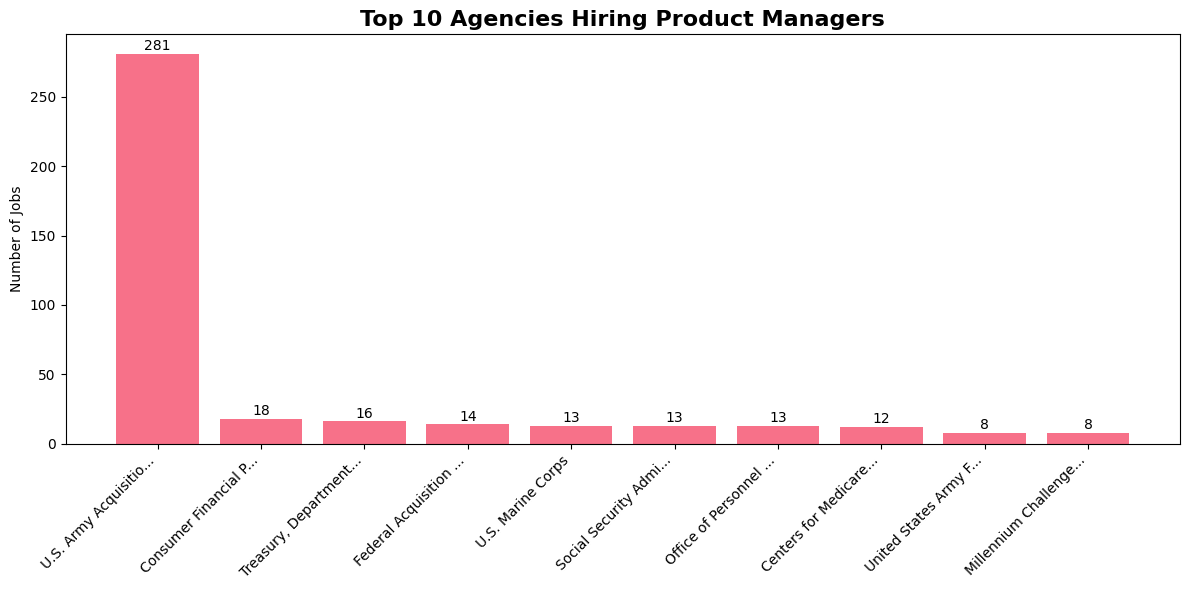

In [11]:
# Top agencies hiring product managers
if len(pm_jobs) > 0:
    pm_agencies = pm_jobs.groupby('hiring_agency_name').size().reset_index(name='count').sort_values('count', ascending=False).head(10)
    
    print("🏢 Top 10 Agencies Hiring Product Managers:")
    print("=" * 70)
    for i, row in pm_agencies.iterrows():
        print(f"{i+1:2d}. {row['hiring_agency_name']:<50} {row['count']:>3} jobs")
    
    # Visualize top PM hiring agencies
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(range(len(pm_agencies)), pm_agencies['count'])
    ax.set_xticks(range(len(pm_agencies)))
    ax.set_xticklabels([agency[:20] + '...' if len(agency) > 20 else agency 
                       for agency in pm_agencies['hiring_agency_name']], rotation=45, ha='right')
    ax.set_title('Top 10 Agencies Hiring Product Managers', fontsize=16, fontweight='bold')
    ax.set_ylabel('Number of Jobs')
    
    # Add value labels
    for i, v in enumerate(pm_agencies['count']):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [14]:
# Product manager job titles analysis
if len(pm_jobs) > 0:
    pm_titles = pm_jobs['position_title'].value_counts()
    
    print("📝 All Product Manager Job Titles:")
    print("=" * 80)
    for i, (title, count) in enumerate(pm_titles.items()):
        print(f"{i+1:2d}. {title:<60} {count:>3} jobs")

📝 All Product Manager Job Titles:
 1. PROGRAM MANAGER (DEPUTY PRODUCT MANAGER ACQUISITION)          43 jobs
 2. Product Manager                                               39 jobs
 3. Deputy Product Manager (Acquisition)                          34 jobs
 4. Program Manager (Deputy Product Manager Acquisition)          31 jobs
 5. Program Manager (Product Lead Acquisition)                    26 jobs
 6. Program Manager (Deputy Product Lead Acquisition)             21 jobs
 7. Assistant Product Manager                                     18 jobs
 8. PROGRAM MANAGER (PRODUCT LEAD ACQUISITION)                    17 jobs
 9. Product Lead (Acquisition)                                    16 jobs
10. PROGRAM MANAGER (DEPUTY PRODUCT LEAD ACQUISITION)             15 jobs
11. Deputy Product Lead (Acquisition)                             12 jobs
12. Business Product Manager                                      12 jobs
13. Product Owner                                                 10 jobs
14. 

## 5. Product Manager DataFrame for Easy Analysis

Loading all product manager jobs into a pandas DataFrame with key fields for easy exploration.

In [13]:
# Load product manager jobs with specific columns
pm_df_query = """
SELECT 
    position_title,
    hiring_agency_name,
    job_series,
    announcement_number,
    position_open_date,
    position_close_date,
    control_number
FROM all_jobs 
WHERE 
    LOWER(position_title) LIKE '%product manager%'
    OR LOWER(position_title) LIKE '%product management%'
    OR LOWER(position_title) LIKE '%product owner%'
    OR LOWER(position_title) LIKE '%product lead%'
    OR LOWER(position_title) LIKE '%head of product%'
    OR LOWER(position_title) LIKE '%director of product%'
    OR LOWER(position_title) LIKE '%vp of product%'
    OR LOWER(position_title) LIKE '%vice president of product%'
    OR LOWER(position_title) LIKE '%chief product officer%'
    OR (LOWER(position_title) LIKE '%product%' AND LOWER(position_title) LIKE '%strategist%')
ORDER BY position_open_date DESC
"""

# Execute query and load into DataFrame
pm_df = conn.execute(pm_df_query).fetchdf()

print(f"📊 Loaded {len(pm_df):,} product manager jobs into DataFrame")
print(f"\nColumns available: {', '.join(pm_df.columns)}")
print(f"\nMost recent 10 product manager jobs:")
pm_df.head(10)

📊 Loaded 537 product manager jobs into DataFrame

Columns available: position_title, hiring_agency_name, job_series, announcement_number, position_open_date, position_close_date, control_number

Most recent 10 product manager jobs:


,position_title,hiring_agency_name,job_series,announcement_number,position_open_date,position_close_date,control_number
0,Program Analyst (Product Manager),Office of Personnel Management,0343,25-SLS-12730491-CTAP,2025-04-28,2025-05-02,836027600
1,Product Manager,Library of Congress,0301,VAR003053,2025-03-14,2025-03-28,833679200
2,PRODUCT OWNER (JUNIOR),Customs and Border Protection,0301,HRM-DE-12698479-JLM,2025-02-28,2025-03-06,832733700
3,Information Technology Specialist (Product Man...,Administrative Office of the U.S. Courts,2210,25-DAS-12656279,2025-02-18,2025-03-11,826059300
4,Acquisition Key Billet Product Manager or Acq...,U.S. Army Acquisition Support Center,0340,MCAD251493900340,2025-02-18,2025-04-18,831720500
5,PROGRAM MANAGER (DEPUTY PRODUCT MANAGER ACQUIS...,U.S. Army Acquisition Support Center,0340,MCAD256397292536,2025-02-03,2025-02-14,830155600
6,Data Product Manager,Other Agencies and Independent Organizations,0343,25-CD-00487-12670552-DHR,2025-01-16,2025-01-20,828408300
7,Program Manager (Currency Product Manager),Bureau of Engraving and Printing,0340,25-BEP-12667675-P,2025-01-15,2025-01-29,828085100
8,Program Manager (Currency Product Manager),Bureau of Engraving and Printing,0340,25-BEP-12667676,2025-01-15,2025-01-29,828085300
9,Business Systems Analyst (Product Owner),Bureau of the Fiscal Service,0501,25-FS-233-MPA,2025-01-14,2025-01-23,827836800
